# Compare group knockoffs

This repeats the **block covariance** simulation in Fig 1 of [Dai and Barber](https://proceedings.mlr.press/v48/daia16.html).  

+ target FDR = 10%
+ $k = 50$ causal variables
+ We generate equi, SDP, MVR, and ME group knockoffs, using true covariance

In [1]:
using Knockoffs
using LinearAlgebra
using Random
using StatsBase
using Statistics
using ToeplitzMatrices
using Distributions
using DataFrames, CSV
using DelimitedFiles
using GLM
using ProgressMeter

function TP(correct_groups, signif_groups)
    return length(signif_groups ∩ correct_groups) / max(1, length(correct_groups))
end
function FDR(correct_groups, signif_groups)
    FP = length(signif_groups) - length(signif_groups ∩ correct_groups) # number of false positives
    return FP / max(1, length(signif_groups))
end
function get_signif_groups(β, groups)
    correct_groups = Int[]
    for i in findall(!iszero, β)
        g = groups[i]
        g ∈ correct_groups || push!(correct_groups, g)
    end
    return correct_groups
end

# provides extra arguments for controlling CCD/PCA convergence criteria
function get_extra_args(method)
#     tol = occursin("sdp", string(method)) ? 0.00001 : 0.0001
    tol = 0.0001
    niter = 100
    inner_pca_iter = 1
    inner_ccd_iter = 1
    outer_iter = round(Int, niter / (inner_pca_iter + inner_ccd_iter))
    if method ∈ [:maxent, :mvr]
        return (outer_iter=outer_iter, inner_pca_iter=inner_pca_iter, 
            inner_ccd_iter=inner_ccd_iter, tol=tol)
    elseif method == :sdp # sdp converges slower, so I use more stringent convergence 
        return (outer_iter=outer_iter, inner_pca_iter=inner_pca_iter, 
            inner_ccd_iter=inner_ccd_iter, tol=tol)
    elseif occursin("block", string(method)) # block update
        return (tol=tol, niter=niter)
    else
        return ()
    end
end
function simulate_data(n::Int, p::Int, G::Int, 
    pi::Int, k::Int, γ::Float64, ρ::Float64, num_v::Int, w::Float64
    ) # pi is group size, G is number of groups, w is factor that purturbs covariance matrix
    groups_true = repeat(1:Int(p/pi), inner=pi)
    Σ = simulate_block_covariance(groups_true, ρ, γ, num_v=num_v, w=w)

    μ = zeros(p)
    X = rand(MvNormal(μ, Σ), n)' |> Matrix
    zscore!(X, mean(X, dims=1), std(X, dims=1))
    β = zeros(p)
    β[1:k] .= rand(Normal(0, 1.0), k)
    shuffle!(β)
    y = X * β + randn(n)

    # define group
    groups = hc_partition_groups(X)
    correct_groups = groups[findall(!iszero, β)] |> unique
    return X, y, β, Σ, μ, groups, correct_groups
end
function run_group_knockoffs(seed; n=500, k=50, ρ=0.5, γ=0.5, verbose=false)
    Random.seed!(seed)
    p = 1000
    pi = 5  # true group sizes
    G = 200 # number of groups
    m = 5 # number of knockoffs per feature
    w = 0.0 # factor to purturb the block covariance structure
    fdr_target = 0.1
    num_v = 0 # number of v to purturb Σ, i.e. Σ = Σ + vv'
    knockoff_methods = [:equi, :maxent, :mvr, :sdp]
#     knockoff_methods = [:equi, :maxent]

    # simulate data
    X, y, β, Σ, μ, groups, correct_groups = simulate_data(n, p, G, pi, k, γ, ρ, num_v, w)

    df = DataFrame(method = Symbol[], power=Float64[], fdr=Float64[], time=Float64[], ssum=Float64[], obj=Float64[])
    for method in knockoff_methods
        # generate group knockoff
        extra_args = get_extra_args(method)
        Random.seed!(seed)
        my_t = @elapsed ko = modelX_gaussian_group_knockoffs(
            X, method, groups, μ, Σ,
            m=m, verbose=verbose; extra_args...
        )

        # feature statistic
        ko_filter = fit_marginal(y, ko, fdrs=[fdr_target])
        my_ssum = sum(abs.(ko.S))
        my_obj = ko.obj
        constraint = eigmin(Symmetric((m+1)/m*Σ - ko.S))
        if constraint < -0.0001
            error("min eval of (m+1)/m*Σ - S) is less than -0.0001")
        end

        # save output
        discovered_groups = ko_filter.selected[1]
        my_power = round(TP(correct_groups, discovered_groups), digits=3)
        my_fdr = round(FDR(correct_groups, discovered_groups), digits=3)
        println("sim $seed $method: power = $(my_power), fdr = $(my_fdr), time = $(my_t), ssum = $(my_ssum), obj=$(my_obj)")
        push!(df, [method, my_power, my_fdr, my_t, my_ssum, my_obj])
    end
    return df
end
function vary_n(seed::Int)
    dir = "/home/groups/sabatti/group_knockoff_simulations/block_cov/vary_n_marginal"
    k = 50
    γ = 0.25
    ρ = 0.75
    verbose=true
    @showprogress for n in 250:250:1000
        simdir = joinpath(dir, "n$n")
        isdir(simdir) || mkpath(simdir)
        df = run_group_knockoffs(seed, n=n, k=k, ρ=ρ, γ=γ, verbose=verbose)
        CSV.write(joinpath(simdir, "sim$seed.csv"), df)
    end
end

# seed = 1111
seed = parse(Int, ARGS[1])
vary_n(seed)
println("finished.")


sim 1111 equi: power = 0.0, fdr = 0.0, time = 17.673043395, ssum = 498.3283174014396, obj=2916.6716825985577
Maxent initial obj = -14684.288015474507
Iter 1 (PCA): obj = -7608.27677889795, δ = 2.491515564380782, t1 = 1.35, t2 = 0.9
Iter 2 (CCD): obj = -7607.855077766292, δ = 0.004325294025249426, t1 = 1.51, t2 = 1.66, t3 = 0.0
Iter 3 (PCA): obj = -7605.367309732659, δ = 0.023223957424403238, t1 = 3.19, t2 = 2.6
Iter 4 (CCD): obj = -7605.243029570826, δ = 0.002492997595737671, t1 = 3.28, t2 = 3.32, t3 = 0.0
Iter 5 (PCA): obj = -7604.429802124148, δ = 0.014514778867225507, t1 = 4.79, t2 = 4.13
Iter 6 (CCD): obj = -7604.391168072553, δ = 0.0014599716690294302, t1 = 4.87, t2 = 4.91, t3 = 0.01
Iter 7 (PCA): obj = -7604.104877270526, δ = 0.009100512523984522, t1 = 6.45, t2 = 5.79
Iter 8 (CCD): obj = -7604.092575952507, δ = 0.0008488339476234628, t1 = 6.54, t2 = 6.54, t3 = 0.01
sim 1111 maxent: power = 0.0, fdr = 0.0, time = 17.055734736, ssum = 2118.7805429923374, obj=-7604.092575952507
sim 

Progress:  50%|████████████████████▌                    |  ETA: 0:00:52

sim 1111 equi: power = 0.0, fdr = 0.0, time = 2.408309392, ssum = 579.3157891899559, obj=3390.6842108100336
Maxent initial obj = -14622.13743834938
Iter 1 (PCA): obj = -6953.214503226589, δ = 2.4915634979032633, t1 = 1.41, t2 = 0.93
Iter 2 (CCD): obj = -6953.192348351325, δ = 0.0043256443477083534, t1 = 1.42, t2 = 1.85, t3 = 0.0
Iter 3 (PCA): obj = -6953.0470670256445, δ = 0.023217013651909413, t1 = 2.99, t2 = 2.61
Iter 4 (CCD): obj = -6953.039335120676, δ = 0.0024933345452640655, t1 = 2.99, t2 = 3.47, t3 = 0.0


Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:21

sim 1111 maxent: power = 0.07, fdr = 0.0, time = 8.936862028, ssum = 3011.517003573108, obj=-6953.039335120676
sim 1111 equi: power = 0.044, fdr = 0.0, time = 2.542136694, ssum = 3674.999999998834, obj=325.0000000011667
Maxent initial obj = -10366.709825268368
Iter 1 (PCA): obj = -6914.66375242968, δ = 0.6124999916236191, t1 = 1.47, t2 = 0.73
Iter 2 (CCD): obj = -6914.66375242968, δ = 0.0, t1 = 1.47, t2 = 1.57, t3 = 0.0
Iter 3 (PCA): obj = -6914.661690163683, δ = 0.00255323654270641, t1 = 3.0, t2 = 2.32
Iter 4 (CCD): obj = -6914.661690163683, δ = 0.0, t1 = 3.0, t2 = 3.22, t3 = 0.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


sim 1111 maxent: power = 0.111, fdr = 0.0, time = 8.841448133, ssum = 3065.052527498334, obj=-6914.661690163683
finished.


In [1]:
function run_repeats()
    script_dir = "/home/groups/sabatti/group_knockoff_simulations"
    for seed in 1:100
        # create .sh file to submit jobs
        filename = joinpath(script_dir, "submit.sh")
        open(filename, "w") do io
            println(io, "#!/bin/bash")
            println(io, "#")
            println(io, "#SBATCH --job-name=block$seed")
            println(io, "#")
            println(io, "#SBATCH --time=24:00:00")
            println(io, "#SBATCH --cpus-per-task=1")
            println(io, "#SBATCH --mem-per-cpu=24G")
            println(io, "#SBATCH --partition=normal,candes,owners,zihuai")
            println(io, "#SBATCH --output=/home/groups/sabatti/group_knockoff_simulations/block_cov/slurms/slurm-%j.out")
            println(io, "")
            println(io, "#save job info on joblog:")
            println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
            println(io, "")
            println(io, "# load the job environment:")
            println(io, "module load julia/1.8.4")
            println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
            println(io, "")
            println(io, "# run code")
            println(io, "echo 'julia $(script_dir)/run_block_cov_marginal.jl $seed'")
            println(io, "julia $(script_dir)/run_block_cov_marginal.jl $seed")
            println(io, "")
            println(io, "#echo job info on joblog:")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
            println(io, "#echo \" \"")
        end
        # submit job
        run(`sbatch $filename`)
        println("submitted sim $seed")
        rm(filename, force=true)
    end
end
run_repeats()

Submitted batch job 20083205
submitted sim 1
Submitted batch job 20083206
submitted sim 2
Submitted batch job 20083207
submitted sim 3
Submitted batch job 20083208
submitted sim 4
Submitted batch job 20083209
submitted sim 5
Submitted batch job 20083210
submitted sim 6
Submitted batch job 20083211
submitted sim 7
Submitted batch job 20083212
submitted sim 8
Submitted batch job 20083213
submitted sim 9
Submitted batch job 20083214
submitted sim 10
Submitted batch job 20083216
submitted sim 11
Submitted batch job 20083217
submitted sim 12
Submitted batch job 20083218
submitted sim 13
Submitted batch job 20083219
submitted sim 14
Submitted batch job 20083220
submitted sim 15
Submitted batch job 20083221
submitted sim 16
Submitted batch job 20083231
submitted sim 17
Submitted batch job 20083233
submitted sim 18
Submitted batch job 20083234
submitted sim 19
Submitted batch job 20083235
submitted sim 20
Submitted batch job 20083237
submitted sim 21
Submitted batch job 20083238
submitted sim 

# Vary n plot

n 250 has 100 success
n 500 has 100 success
n 750 has 100 success
n 1000 has 100 success


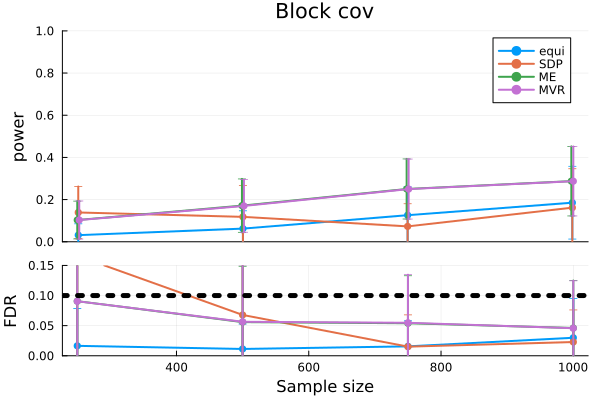

In [3]:
# load packages
using DataFrames, CSV
using Plots
using LinearAlgebra
using Statistics
gr(fmt=:png);

function summarize_block_cov_vary_n(n::Int)
    dir = "/home/groups/sabatti/group_knockoff_simulations/block_cov/vary_n_marginal"
    equi_powers, equi_fdrs, equi_times, equi_ssums, equi_obj = [], [], [], [], []
    maxent_powers, maxent_fdrs, maxent_times, maxent_ssums, maxent_obj = [], [], [], [], []
    mvr_powers, mvr_fdrs, mvr_times, mvr_ssums, mvr_obj = [], [], [], [], []
    sdp_powers, sdp_fdrs, sdp_times, sdp_ssums, sdp_obj = [], [], [], [], []
    for seed in 1:100
        try
            result = CSV.read(joinpath(dir, "n$(n)", "sim$seed.csv"), DataFrame)
            push!(equi_powers, result[1, "power"]); push!(equi_fdrs, result[1, "fdr"])
            push!(maxent_powers, result[2, "power"]); push!(maxent_fdrs, result[2, "fdr"])
            push!(mvr_powers, result[3, "power"]); push!(mvr_fdrs, result[3, "fdr"])
            push!(sdp_powers, result[4, "power"]); push!(sdp_fdrs, result[4, "fdr"])
        catch
            continue
        end
    end
    println("n $n has $(length(equi_powers)) success")
    # save power/FDR result
    return equi_powers, maxent_powers, mvr_powers, sdp_powers, 
        equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs
end
function block_cov_vary_n_plot(;ns = 250:250:1000)
    equi_powers_mean, equi_fdrs_mean, equi_powers_std, equi_fdrs_std = [], [], [], []
    sdp_powers_mean, sdp_fdrs_mean, sdp_powers_std, sdp_fdrs_std = [], [], [], []
    maxent_powers_mean, maxent_fdrs_mean, maxent_powers_std, maxent_fdrs_std = [], [], [], []
    mvr_powers_mean, mvr_fdrs_mean, mvr_powers_std, mvr_fdrs_std = [], [], [], []
    
    # summarize results
    for n in ns
        equi_powers, maxent_powers, mvr_powers, sdp_powers, 
            equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs = 
            summarize_block_cov_vary_n(n)
        push!(equi_powers_mean, mean(equi_powers)); push!(equi_powers_std, std(equi_powers))
        push!(equi_fdrs_mean, mean(equi_fdrs)); push!(equi_fdrs_std, std(equi_fdrs))
        push!(sdp_powers_mean, mean(sdp_powers)); push!(sdp_powers_std, std(sdp_powers))
        push!(sdp_fdrs_mean, mean(sdp_fdrs)); push!(sdp_fdrs_std, std(sdp_fdrs))
        push!(maxent_powers_mean, mean(maxent_powers)); push!(maxent_powers_std, std(maxent_powers))
        push!(maxent_fdrs_mean, mean(maxent_fdrs)); push!(maxent_fdrs_std, std(maxent_fdrs))
        push!(mvr_powers_mean, mean(mvr_powers)); push!(mvr_powers_std, std(mvr_powers))
        push!(mvr_fdrs_mean, mean(mvr_fdrs)); push!(mvr_fdrs_std, std(mvr_fdrs))
    end
    
    # power plot
    title = "Block cov"
    power_plt = plot(ns, equi_powers_mean, yerr=equi_powers_std, xtick=false, shape=:circle,
        ylabel="power", label="equi", w=2, ylim=(0, 1.0), title=title, markerstrokecolor=:auto, capsize = 0)
    plot!(ns, sdp_powers_mean, yerr=sdp_powers_std, label = "SDP", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)
    plot!(ns .- 1.5, maxent_powers_mean, yerr=maxent_powers_std, label = "ME", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)
    plot!(ns .+ 1.5, mvr_powers_mean, yerr=mvr_powers_std, label = "MVR", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)

    # FDR plots
    fdr_plt = plot(ns, equi_fdrs_mean, xlabel="Sample size", yerr=equi_fdrs_std, 
        ylabel="FDR", label="equi", w=2, ylim=(0, 0.15), shape=:circle, markerstrokecolor=:auto, )
    plot!(ns, sdp_fdrs_mean, label = "SDP", w=2, shape=:circle, yerr=sdp_fdrs_std, markerstrokecolor=:auto)
    plot!(ns, maxent_fdrs_mean, label = "ME", w=2, shape=:circle, yerr=maxent_fdrs_std, markerstrokecolor=:auto)
    plot!(ns, mvr_fdrs_mean, label = "MVR", w=2, shape=:circle, yerr=mvr_fdrs_std, markerstrokecolor=:auto)
    hline!(fdr_plt, [0.1], label = "target FDR", linestyle=:dot, w=5, color=:black, legend=false)
    
    return power_plt, fdr_plt
end
power_plt, fdr_plt = block_cov_vary_n_plot()
plot(power_plt, fdr_plt, layout = grid(2, 1, heights=[0.7 ,0.3]))
